# Rebalancing Benchmark for Catboost MultiClass Classification

Since only 22 songs are proposed each day on the 2k dataset, the class are unbalanced with the following proportions : <br/>
- 50 : 0,18%
- 40 : 0,18%
- 30 : 0,18%
- 20 : <0,18%
- 10 : <0,18%
- MC : 0,09%
- 20k : 0,18%
- PP : 99,02%

Hence, we clearly have an unbalanced dataset and we need to address this problem

## I. Dataset loading

In [1]:
import pandas as pd
from catboost import CatBoostClassifier, Pool
import sklearn.metrics as skl
import matplotlib.pyplot as plt
import os
import shutil
import numpy as np

homePath = "C:/Users/thoma/OneDrive - CentraleSupelec/NOPLP/code/ML"
os.chdir(homePath)

# Import du fichier util
shutil.copy(homePath + "/util.py", homePath + "/etudes/")
import util

In [6]:
# Chargement du dataset
print("Dataset loading...")
df = pd.read_csv("data/lossBenchmarkData.csv", sep=";")

# Data Cleaning
print("Data cleaning...")
df = df.drop(columns=['Unnamed: 0', 'id', 'Chanson_id'])
reversed_cat = {'50': 1, '40': 2, '30': 3,
                '20': 4, '10': 5, 'MC': 6, '20k': 7, None: 8}
df = df.replace({'categorie': reversed_cat})

# Split train / test
print("Spliting in train and test...")
train = df[0:int(len(df)*0.8)]
print("Taille du dataset de train : " + str(len(train)))
test = df[int(len(df)*0.8)+1:]
print("Taille du dataset de test : " + str(len(test)))
train_labels = train['categorie']
trainSL = train.drop(columns=['categorie'])
train_data = trainSL
test_labels = test['categorie']
test = test.drop(columns=['categorie'])
test_data = test
test_pool = Pool(test_data,
                 test_labels,
                 cat_features=['titre', 'artiste', 'clusterid'])

Dataset loading...
Data cleaning...
Spliting in train and test...
Taille du dataset de train : 480160
Taille du dataset de test : 120040


## II. Sans rééquilibrage

Let see what happens without rebalancing the dataset

In [4]:
# Training model
print("Training the CatBoost model...")
model = CatBoostClassifier(iterations=10,
                           depth=10,
                           learning_rate=1,
                           loss_function='MultiClassOneVsAll',
                           class_weights=[1, 0, 0.1, 0.5, 0.1, 5, 5, 0.1],
                           verbose=True)
model.fit(train_data, train_labels, cat_features=[
          'titre', 'artiste', 'clusterid'])

Training the CatBoost model...
0:	learn: 0.2000040	total: 5.19s	remaining: 46.7s
1:	learn: 0.1318595	total: 10.3s	remaining: 41.3s
2:	learn: 0.1100145	total: 15.7s	remaining: 36.5s
3:	learn: 0.1009747	total: 21.6s	remaining: 32.4s
4:	learn: 0.0964956	total: 27.3s	remaining: 27.3s
5:	learn: 0.0934921	total: 33s	remaining: 22s
6:	learn: 0.0915826	total: 38.1s	remaining: 16.3s
7:	learn: 0.0875086	total: 43.5s	remaining: 10.9s
8:	learn: 0.0851794	total: 48.8s	remaining: 5.43s
9:	learn: 0.0826259	total: 54.1s	remaining: 0us


Predicting on the test set...
Confusion matrix :


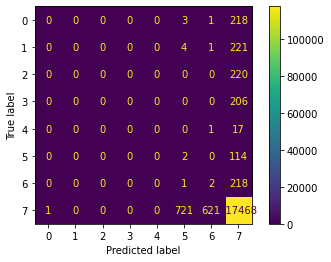

In [5]:
# Prediction on test set
print("Predicting on the test set...")
preds_class = model.predict(test_pool)
preds_proba = model.predict_proba(test_pool)
preds = model.predict_log_proba(test_pool)

# Modification du dataset de test
test_data["pred"] = preds_class
test_data["labels"] = test_labels
test_data[["1", "2", "3", "4", "5", "6", "7", "8"]] = preds

# Confusion matrix
print("Confusion matrix :")
test_data["pred"] = preds_class
test_data["labels"] = test_labels
confusionMatrix = skl.confusion_matrix(
    test_data['labels'], test_data['pred'])
dispCM = skl.ConfusionMatrixDisplay(confusionMatrix)
dispCM.plot()
plt.show()

## III. Metric definition

First, what is the most precious information for us to get is about the Mêmes Chansons and te 20k Chansons. We will thus create a metric that only takes into account these two classes. <br/>
We want two things : <br/>
- We **absolutely** don't want to miss songs, especially MC songs
- We don't want to learn too many songs, because, physically, we can revise only 20-30 songs per day

For the first requirement, we will consider the precisions on the two classes that we care about. Let $a_{ij}$ be the coefficient at the $i-th$ row and $j-th$ column of the confusion matrix :
$$P_5 = \frac{a_{55}}{\sum_{j = 0}^7a_{5j}}$$
The same expression can be obtained for the 20k songs replacing 5 by 6.
Then, since we absolutely don't want to miss MC songs, we can't compute a weighted mean of the two metrics with a higher weight for $P_5$.
$$Precision(\lambda) = \lambda P_5 + (1-\lambda) P_6$$
We will take $\lambda = 0.9$

For the second requirement, we will do the same work with the recalls on both classes.
$$R_5 = \frac{a_{55}}{\sum_{i = 0}^7a_{i5}}$$
Then,
$$Recall(\mu) = \mu R_5 + (1-\mu) R_6$$
Let's take $\mu = 0.5$

We then compute a classical $F1-score$ with knowing the precision and the recall of the problem :
$$F1 = \frac{2}{\frac{1}{Precision(\lambda)} + \frac{1}{Recall(\mu)}}$$

### 1. Application for the test case without rebalancing

In [6]:
def precisionOrRecall(metric, c):
    res = 0
    if metric == "Precision":
        res = confusionMatrix[c, c]/sum(confusionMatrix[c,])
    elif metric == "Recall":
        res = confusionMatrix[c, c]/sum(confusionMatrix[:,c])
    else:
        raise("metric argument must be either Precision or Recall")
    return round(res * 100, 1)

def F1score(p, r):
    if p == 0 and r == 0:
        return 0
    else:
        return round(2/(1/p + 1/r), 1)

# Calcul de la précision
P5 = precisionOrRecall("Precision", 5)
print("P5 = {0}".format(P5))
P6 = precisionOrRecall("Precision", 6)
print("P6 = {0}".format(P6))
l = 0.9
precision = l*P5 + (1-l)*P6
print("Precision = {0}".format(precision))

# Calcul du recall
R5 = precisionOrRecall("Recall", 5)
print("R5 = {0}".format(R5))
R6 = precisionOrRecall("Recall", 6)
print("R6 = {0}".format(R6))
mu = 0.5
recall = mu*R5 + (1-mu)*R6
print("Recall = {0}".format(recall))

# Calcul du F1-score
F1 = F1score(precision, recall)
print("F1-score = {0}".format(F1))

P5 = 1.7
P6 = 0.9
Precision = 1.62
R5 = 0.3
R6 = 0.3
Recall = 0.3
F1-score = 0.5


**Conclusion :** Si on n'utilise pas de méthode de rebalancing, les résultats sont pourris

## IV. Echantillonage en enlevant des PP

La première stratégie consiste, pour chaque émission, à ne pas garder l'ensemble des chansons du dataset qui ne sont pas passées. On en garde seulement une proportion $\tau$, quitte à faire baisser la taille de l'échantillon.

Pour ce faire, on split le dataset entre les chansons qui ne passent pas $PP$ et celles qui passent $P$, puis on concatène $dataset = P + \tau PP$

In [7]:
def buildDataset(df, tau):
    P = df[df.categorie != 8]
    PP = df[df.categorie == 8]
    tauPP = PP.sample(frac = tau)
    res = pd.concat([P, tauPP])
    return res

exempleBuildDataset = buildDataset(train, 0.01)
exempleBuildDataset.sample(5)

,titre,année,decennie,artiste,clusterid,deltadate,deltadatemc,deltadatemcma,deltadate20k,deltadate20kma,tauxchoisies,categorie
430520,Les ricains,1967,1960,Sardou Michel,1,223.0,NaN,41.0,NaN,33.0,0.000000,8
140150,Pile ou face,1987,1980,Charby Corynne,3,212.0,NaN,NaN,NaN,NaN,0.000000,8
135696,On va s'aimer,1983,1980,Montagné Gilbert,7,68.0,104.0,33.0,NaN,49.0,1.000000,8
13021,Chanson populaire,1973,1970,François Claude,9,133.0,198.0,38.0,NaN,74.0,1.000000,8
414094,Coups et blessures,2012,2010,BB Brunes,3,71.0,NaN,76.0,NaN,368.0,0.777778,8


### 1. Petit test avec $\tau = 1\%$

Ici on a pris $\tau = 1\%$, entrainons le modèle et calculons le F1-score

Training the CatBoost model...
Predicting on the test set...
Confusion matrix :


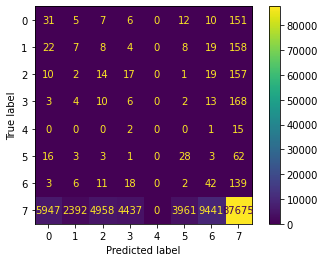

In [13]:
# Split train / test
train_labels = exempleBuildDataset['categorie']
trainSL = exempleBuildDataset.drop(columns=['categorie'])
train_data = trainSL

# Training model
model = util.trainModel(train_data, train_labels, ['titre', 'artiste', 'clusterid'])

# Prediction on test set
print("Predicting on the test set...")
preds_class = model.predict(test_pool)
preds_proba = model.predict_proba(test_pool)
preds = model.predict_log_proba(test_pool)

# Modification du dataset de test
test_data["pred"] = preds_class
test_data["labels"] = test_labels
test_data[["1", "2", "3", "4", "5", "6", "7", "8"]] = preds

# Confusion matrix
print("Confusion matrix :")
test_data["pred"] = preds_class
test_data["labels"] = test_labels
confusionMatrix = skl.confusion_matrix(
    test_data['labels'], test_data['pred'])
dispCM = skl.ConfusionMatrixDisplay(confusionMatrix)
dispCM.plot()
plt.show()

In [14]:
# Calcul de la précision
P5 = precisionOrRecall("Precision", 5)
print("P5 = {0}".format(P5))
P6 = precisionOrRecall("Precision", 6)
print("P6 = {0}".format(P6))
l = 0.9
precision = round(l*P5 + (1-l)*P6, 1)
print("Precision = {0}".format(precision))

# Calcul du recall
R5 = precisionOrRecall("Recall", 5)
print("R5 = {0}".format(R5))
R6 = precisionOrRecall("Recall", 6)
print("R6 = {0}".format(R6))
mu = 0.5
recall = round(mu*R5 + (1-mu)*R6, 1)
print("Recall = {0}".format(recall))

# Calcul du F1-score
F1 = F1score(precision, recall)
print("F1-score = {0}".format(F1))

P5 = 24.1
P6 = 19.0
Precision = 23.6
R5 = 0.7
R6 = 0.4
Recall = 0.6
F1-score = 1.2


### 2. Recherche de la proportion $\tau$ optimale

On va itérer sur les différentes valeurs de $\tau$ suivantes : $\{0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1\}$ et regarder l'évolution des trois métriques suivantes : précision, recall et F1-score.

In [3]:
def trainModel(train_data, train_labels, cat_features, class_weight=[1]*8, loss="MultiClass"):
    
    print("Training the CatBoost model...")
    model = CatBoostClassifier(iterations=10,
                               depth=10,
                               learning_rate=1,
                               loss_function=loss,
                               class_weights=class_weight,
                               verbose=False)
    model.fit(train_data, train_labels, cat_features=cat_features)

    return model

def metricCalculation(confusionMatrix, verbose=False):
    
    # Calcul de la précision
    P5 = util.precisionOrRecall("Precision", 5, confusionMatrix)
    P6 = util.precisionOrRecall("Precision", 6, confusionMatrix)
    l = 0.9
    precision = round(l*P5 + (1-l)*P6, 1)

    # Calcul du recall
    R5 = util.precisionOrRecall("Recall", 5, confusionMatrix)
    R6 = util.precisionOrRecall("Recall", 6, confusionMatrix)
    mu = 0.5
    recall = round(mu*R5 + (1-mu)*R6, 1)

    # Calcul du F1-score
    F1 = util.F1score(precision, recall)

    # Affichage
    if verbose:
        print("P5 = {0}".format(P5))
        print("P6 = {0}".format(P6))
        print("Precision = {0}".format(precision))
        print("R5 = {0}".format(R5))
        print("R6 = {0}".format(R6))
        print("Recall = {0}".format(recall))
        print("F1-score = {0}".format(F1))

    return {"Precision": precision, "Recall": recall, "F1score": F1}


In [11]:
taus = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3]
def experimentTau(taus):

    precisions, recalls, F1scores = [], [], []

    for tau in taus:

        print(tau)    
        # Fabrication du dataset de train
        dataset = buildDataset(train, tau)

        # Split train / test
        train_labels = dataset['categorie']
        trainSL = dataset.drop(columns=['categorie'])
        train_data = trainSL

        # Training model
        model = trainModel(train_data, train_labels, cat_features = ['titre', 'artiste', 'clusterid'], class_weight= [0.25, 0.65, 0.325, 0.425, 0.175, 1.9375, 3.875, 0.1], loss = "MultiClassOneVsAll")

        # Confusion matrix
        confusionMatrix = util.confusionMatrixCalculation(model, test_pool, test_data, test_labels)

        # Calcul des métriques
        metriques = metricCalculation(confusionMatrix)
        precisions.append(metriques["Precision"])
        recalls.append(metriques["Recall"])
        F1scores.append(metriques["F1score"])
        
    return {"p": precisions, "r": recalls, "F": F1scores}

In [20]:
N = 10

def experimentMeilleurTau(taus, N):
    precisions = np.array([0, 0, 0, 0, 0, 0])
    recalls = np.array([0, 0, 0, 0, 0, 0])
    F1scores = np.array([0, 0, 0, 0, 0, 0])

    for i in range(N):
        print(i+1)
        resExp = experimentTau(taus)
        print(precisions)
        print(resExp["p"])
        print(np.array(resExp["p"]))
        precisions = precisions + np.array(resExp["p"])
        recalls = recalls + np.array(resExp["r"])
        F1scores = F1scores + np.array(resExp["F"])

    precisions = precisions / N
    recalls = recalls / N
    F1scores = F1scores / N

    # Affichage
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
    fig.set_size_inches(30, 20)
    ax1.set_xscale("log")
    ax2.set_xscale("log")
    ax3.set_xscale("log")
    ax1.plot(taus, precisions)
    ax1.set_title("Precision")
    ax2.plot(taus, recalls)
    ax2.set_title("Recall")
    ax3.plot(taus, F1scores)
    ax3.set_title("F1-score")
    plt.show()

In [ ]:
experimentMeilleurTau(taus, N)

**Conclusion** : Regardons d'un peu plus près ce qui se passe sur la zone entre *3%* et *100%*, toujours en échelle log. En attendant, on utilise la valeur $\tau = 30\%$

On zoome ensuite sur la zone maximisant le *F1 score* pour trouver le meilleur tau. Pour calculer les **\tau** que l'on essaie on utilise cette petite fonction qui calcule des intervalles réguliers en échelle log.

In [17]:
from math import log
borne_inf = 0.03
borne_sup = 1
nbCoupures = 5
breaksLog = np.array([log(borne_inf) + k*(log(borne_sup)-log(borne_inf))/nbCoupures for k in range(nbCoupures+1)])
taus = np.exp(breaksLog)
taus

array([0.03      , 0.05381885, 0.09654894, 0.17320508, 0.31072325,
       0.55742556, 1.        ])

In [21]:
experimentMeilleurTau(taus, N)

1
0.029999999999999995
Training the CatBoost model...
Predicting on the test set...
Confusion matrix :
0.05381884571241647
Training the CatBoost model...
Predicting on the test set...
Confusion matrix :
0.09654893846056296
Training the CatBoost model...
Predicting on the test set...
Confusion matrix :
0.17320508075688767
Training the CatBoost model...
Predicting on the test set...
Confusion matrix :
0.31072325059538586
Training the CatBoost model...
Predicting on the test set...
Confusion matrix :
0.5574255561017865
Training the CatBoost model...
Predicting on the test set...
Confusion matrix :
0.9999999999999996
Training the CatBoost model...
Predicting on the test set...
Confusion matrix :
[0 0 0 0 0 0]
[63.4, 47.9, 28.6, 22.4, 8.7, 3.4, 0.2]
[63.4 47.9 28.6 22.4  8.7  3.4  0.2]


ValueError: operands could not be broadcast together with shapes (6,) (7,) 